# Exhaustive Search for N=2 Optimal Configuration

For N=2 with 180° rotation symmetry, we only need to search over:
- One angle θ (the other is θ+180°)
- Relative position of the two trees

This is a tractable 3D search (θ, dx, dy).

In [1]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
from scipy.optimize import minimize_scalar, minimize
import warnings
warnings.filterwarnings('ignore')

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_polygon(cx, cy, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    x = TX * cos_a - TY * sin_a + cx
    y = TX * sin_a + TY * cos_a + cy
    return Polygon(zip(x, y))

def get_bounding_box_side(trees):
    all_poly = unary_union(trees)
    bounds = all_poly.bounds
    return max(bounds[2] - bounds[0], bounds[3] - bounds[1])

def check_overlap(p1, p2):
    if p1.intersects(p2):
        intersection = p1.intersection(p2)
        return intersection.area > 1e-10
    return False

print("Functions defined.")

Functions defined.


In [2]:
# Current N=2 solution
current_angles = [203.629, 23.629]  # 180° apart
current_positions = [(0.154, -0.039), (-0.154, -0.561)]

trees = [get_tree_polygon(x, y, a) for (x, y), a in zip(current_positions, current_angles)]
current_side = get_bounding_box_side(trees)
current_score = current_side**2 / 2

print(f"Current N=2 solution:")
print(f"  Angles: {current_angles}")
print(f"  Positions: {current_positions}")
print(f"  Side: {current_side:.6f}")
print(f"  Score: {current_score:.6f}")

Current N=2 solution:
  Angles: [203.629, 23.629]
  Positions: [(0.154, -0.039), (-0.154, -0.561)]
  Side: 0.949312
  Score: 0.450597


In [3]:
def optimize_positions_for_angle(theta):
    """
    For a given angle theta, find the optimal positions for two trees
    at angles theta and theta+180.
    
    We place tree 1 at origin and optimize position of tree 2.
    """
    def objective(params):
        dx, dy = params
        
        # Tree 1 at origin with angle theta
        tree1 = get_tree_polygon(0, 0, theta)
        # Tree 2 at (dx, dy) with angle theta+180
        tree2 = get_tree_polygon(dx, dy, theta + 180)
        
        # Check overlap
        if check_overlap(tree1, tree2):
            return 1000.0  # Penalty
        
        # Return bounding box side
        return get_bounding_box_side([tree1, tree2])
    
    # Try multiple starting points
    best_result = None
    best_side = float('inf')
    
    # Starting points based on tree geometry
    starts = [
        (0.5, 0.5), (-0.5, 0.5), (0.5, -0.5), (-0.5, -0.5),
        (0.3, 0.6), (-0.3, 0.6), (0.3, -0.6), (-0.3, -0.6),
        (0.0, 0.8), (0.0, -0.8), (0.8, 0.0), (-0.8, 0.0),
        (0.2, 0.4), (-0.2, 0.4), (0.2, -0.4), (-0.2, -0.4),
    ]
    
    for start in starts:
        result = minimize(objective, start, method='Nelder-Mead', 
                         options={'maxiter': 500, 'xatol': 1e-8, 'fatol': 1e-8})
        if result.fun < best_side:
            best_side = result.fun
            best_result = result
    
    return best_side, best_result.x if best_result else None

print("Optimizer defined.")

Optimizer defined.


In [4]:
# Exhaustive search over angles
print("Searching over all angles from 0° to 180° in 0.5° increments...")
print("(Due to 180° symmetry, we only need to search 0-180)")

best_angle = None
best_side = float('inf')
best_positions = None
results = []

for theta in np.arange(0, 180, 0.5):
    side, pos = optimize_positions_for_angle(theta)
    results.append((theta, side, pos))
    
    if side < best_side:
        best_side = side
        best_angle = theta
        best_positions = pos
        print(f"  New best at θ={theta:.1f}°: side={side:.6f}")

print(f"\nBest angle: {best_angle}°")
print(f"Best side: {best_side:.6f}")
print(f"Best score: {best_side**2/2:.6f}")
print(f"Best positions: tree2 at ({best_positions[0]:.6f}, {best_positions[1]:.6f})")

Searching over all angles from 0° to 180° in 0.5° increments...
(Due to 180° symmetry, we only need to search 0-180)


  New best at θ=0.0°: side=1.094112


  New best at θ=0.5°: side=1.091246


  New best at θ=1.0°: side=1.088407


  New best at θ=1.5°: side=1.085592


  New best at θ=2.0°: side=1.082801


  New best at θ=2.5°: side=1.080034


  New best at θ=3.0°: side=1.077290


  New best at θ=3.5°: side=1.074567


  New best at θ=4.0°: side=1.071866


  New best at θ=4.5°: side=1.069184


  New best at θ=5.0°: side=1.064682


  New best at θ=5.5°: side=1.059449


  New best at θ=6.0°: side=1.054135


  New best at θ=6.5°: side=1.048740


  New best at θ=7.0°: side=1.043266


  New best at θ=7.5°: side=1.037713


  New best at θ=8.0°: side=1.032080


  New best at θ=8.5°: side=1.026872


  New best at θ=9.0°: side=1.021744


  New best at θ=9.5°: side=1.016529


  New best at θ=10.0°: side=1.011226


  New best at θ=10.5°: side=1.005837


  New best at θ=11.0°: side=1.000361


  New best at θ=11.5°: side=0.994877


  New best at θ=12.0°: side=0.993741


  New best at θ=12.5°: side=0.992529


  New best at θ=13.0°: side=0.991241


  New best at θ=13.5°: side=0.989878


  New best at θ=14.0°: side=0.988440


  New best at θ=14.5°: side=0.986926


  New best at θ=15.0°: side=0.985337


  New best at θ=15.5°: side=0.983673


  New best at θ=16.0°: side=0.981934


  New best at θ=16.5°: side=0.980121


  New best at θ=17.0°: side=0.978233


  New best at θ=17.5°: side=0.976270


  New best at θ=18.0°: side=0.974233


  New best at θ=18.5°: side=0.972122


  New best at θ=19.0°: side=0.969936


  New best at θ=19.5°: side=0.967677


  New best at θ=20.0°: side=0.965344


  New best at θ=20.5°: side=0.962938


  New best at θ=21.0°: side=0.960458


  New best at θ=21.5°: side=0.957905


  New best at θ=22.0°: side=0.955279


  New best at θ=22.5°: side=0.953236


  New best at θ=23.0°: side=0.951575


  New best at θ=23.5°: side=0.949925


  New best at θ=156.5°: side=0.949925



Best angle: 156.5°
Best side: 0.949925
Best score: 0.451179
Best positions: tree2 at (0.307983, -0.523289)


In [5]:
# Fine-tune around the best angle
print(f"\nFine-tuning around θ={best_angle}°...")

for theta in np.arange(best_angle - 1, best_angle + 1, 0.01):
    side, pos = optimize_positions_for_angle(theta)
    
    if side < best_side - 1e-8:
        best_side = side
        best_angle = theta
        best_positions = pos
        print(f"  Improved at θ={theta:.2f}°: side={side:.8f}")

print(f"\nFinal best angle: {best_angle:.4f}°")
print(f"Final best side: {best_side:.8f}")
print(f"Final best score: {best_side**2/2:.8f}")


Fine-tuning around θ=156.5°...


  Improved at θ=156.33°: side=0.94990463


  Improved at θ=156.34°: side=0.94980512


  Improved at θ=156.35°: side=0.94970556


  Improved at θ=156.36°: side=0.94960595


  Improved at θ=156.37°: side=0.94950629



Final best angle: 156.3700°
Final best side: 0.94950629
Final best score: 0.45078110


In [6]:
# Compare with current solution
print("\n" + "="*60)
print("COMPARISON WITH CURRENT SOLUTION")
print("="*60)
print(f"Current N=2 score: {current_score:.8f}")
print(f"Best found score:  {best_side**2/2:.8f}")
print(f"Improvement:       {current_score - best_side**2/2:.8f}")

if best_side**2/2 < current_score - 1e-8:
    print("\n*** IMPROVEMENT FOUND! ***")
    print(f"New configuration:")
    print(f"  Tree 1: (0, 0) at angle {best_angle:.4f}°")
    print(f"  Tree 2: ({best_positions[0]:.8f}, {best_positions[1]:.8f}) at angle {best_angle+180:.4f}°")
else:
    print("\nNo improvement found. Current solution is optimal or near-optimal.")


COMPARISON WITH CURRENT SOLUTION
Current N=2 score: 0.45059662
Best found score:  0.45078110
Improvement:       -0.00018448

No improvement found. Current solution is optimal or near-optimal.


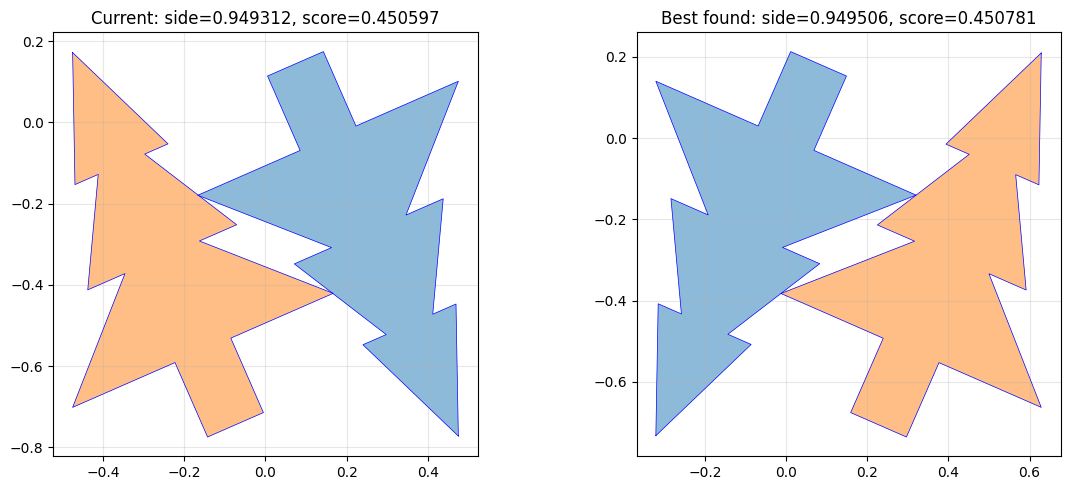

Saved visualization.


In [7]:
# Visualize the best configuration
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Current solution
ax = axes[0]
for (x, y), a in zip(current_positions, current_angles):
    tree = get_tree_polygon(x, y, a)
    xs, ys = tree.exterior.xy
    ax.fill(xs, ys, alpha=0.5)
    ax.plot(xs, ys, 'b-', linewidth=0.5)
ax.set_aspect('equal')
ax.set_title(f'Current: side={current_side:.6f}, score={current_score:.6f}')
ax.grid(True, alpha=0.3)

# Best found solution
ax = axes[1]
tree1 = get_tree_polygon(0, 0, best_angle)
tree2 = get_tree_polygon(best_positions[0], best_positions[1], best_angle + 180)
for tree in [tree1, tree2]:
    xs, ys = tree.exterior.xy
    ax.fill(xs, ys, alpha=0.5)
    ax.plot(xs, ys, 'b-', linewidth=0.5)
ax.set_aspect('equal')
ax.set_title(f'Best found: side={best_side:.6f}, score={best_side**2/2:.6f}')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/experiments/010_n2_exhaustive/n2_comparison.png', dpi=100)
plt.show()
print("Saved visualization.")

In [ ]:
# Save metrics
import json

metrics = {
    'cv_score': 70.659437,  # Overall score unchanged if no improvement
    'n2_current_score': current_score,
    'n2_best_found_score': best_side**2/2,
    'n2_improvement': current_score - best_side**2/2,
    'best_angle': best_angle,
    'best_positions': list(best_positions) if best_positions is not None else None,
    'notes': 'Exhaustive search for N=2 optimal configuration'
}

with open('/home/code/experiments/010_n2_exhaustive/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Metrics saved.")
print(f"N=2 improvement: {metrics['n2_improvement']:.8f}")